In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")

### EX 6.2

In [4]:
df = pd.read_table("glucose.dat", names=['glucose'])
nrv = stats.norm(loc=df.glucose.mean(), scale=df.glucose.std())
xs = np.linspace(25, 230, num=10000)

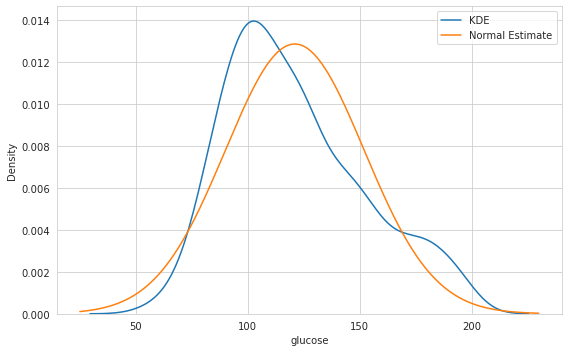

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(df.glucose, label="KDE", ax=ax)
ax.plot(xs, nrv.pdf(xs), label="Normal Estimate")
ax.legend()

fig.tight_layout()
fig.show()

In [22]:
def semi_normal_prec_post(data, prior_var, prior_sample, mean):
    n = data.shape[0]
    post_sample = prior_sample + n
    post_var = 1/post_sample * (prior_var*prior_sample + ((data-mean)**2).sum())

    return post_sample/2, post_var*post_sample/2

def semi_normal_mean_post(data, prior_mean, prior_var, prec):
    n = data.shape[0]
    prior_prec = 1 / prior_var

    post_prec = prior_prec + n * prec
    post_mean = (prior_prec/post_prec * prior_mean) + (data.sum()/post_prec * prec)

    return post_mean, 1/post_prec

np.random.seed(235234)

# observations
Y = df = pd.read_table("glucose.dat", names=['glucose']).glucose
N = Y.shape[0]

# prior parameters
a = b = 1
θ_mean0, θ_var0 = 120, 1000
γ_var0, γ_sample0 = 1000, 10

# initization
n_epochs = 10000
samples = []

p = 0.5
X = np.random.binomial(1, p, N) + 1
N1, N2 = (X==1).sum(), (X==2).sum()

θ1, γ1 = Y.mean(), 1/Y.var()
θ2, γ2 = Y.mean(), 1/Y.var()

for epoch in range(n_epochs):
    p = stats.beta(a+N1, b+N2).rvs()
    Y_p1 = stats.norm(loc=θ1, scale=np.sqrt(1/γ1)).pdf(Y)
    Y_p2 = stats.norm(loc=θ2, scale=np.sqrt(1/γ2)).pdf(Y)

    p_N = (Y_p1*p) / (Y_p1*p + Y_p2*(1-p)) 
    X = np.random.binomial(1, p_N, N) + 1
    N1, N2 = (X==1).sum(), (X==2).sum()

    γ1_post_sample, γ1_post_var = semi_normal_prec_post(Y[X==1], γ_var0, γ_sample0, θ1)
    γ1 = np.random.gamma(γ1_post_sample/2, 1/(γ1_post_var*γ1_post_sample/2))

    γ2_post_sample, γ2_post_var = semi_normal_prec_post(Y[X==2], γ_var0, γ_sample0, θ2)
    γ2 = np.random.gamma(γ2_post_sample/2, 1/(γ2_post_var*γ2_post_sample/2))

    θ1_post_mean, θ1_post_var = semi_normal_mean_post(Y[X==1], θ_mean0, θ_var0, γ1)
    θ1 = np.random.normal(θ1_post_mean, np.sqrt(θ1_post_var))

    θ2_post_mean, θ2_post_var = semi_normal_mean_post(Y[X==2], θ_mean0, θ_var0, γ2)
    θ2 = np.random.normal(θ2_post_mean, np.sqrt(θ2_post_var))

    # y posterior
    if np.random.uniform() < p:
        y_post = np.random.normal(θ1, np.sqrt(1/γ1))
    else:
        y_post = np.random.normal(θ2, np.sqrt(1/γ2))

    samples.append((θ1, θ2, y_post))

In [23]:
S = pd.DataFrame(samples)

<AxesSubplot:xlabel='2', ylabel='Density'>

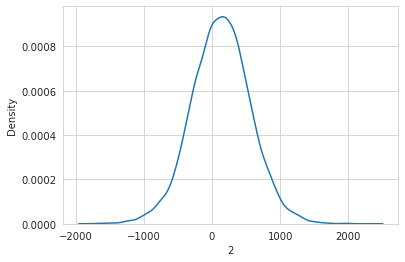

In [27]:
sns.kdeplot(S[2])